# AEWS Python Notebook 07a: saving WQ data to file

**Author**: Eric Lehmann, CSIRO Data61  
**Date**: 03 May 2016

**Note**: The Python code below is "rudimentary" etc. etc. Priority is here given to code interpretability rather than execution efficiency.

**Note**: this notebook should be accessible and viewable at [https://github.com/eric542/agdc_v2/tree/master/notebooks](https://github.com/eric542/agdc_v2/tree/master/notebooks).

## Summary

In this notebook, we introduce / review the following concepts:

* loading PQ-masked Landsat / WQ data for an area and time range of interest, using AE/EE
* "removing" duplicated dates from the dataset
* reproject WQ data to geodetic
* loading WOFS data for the same area
* creating and applying the WOFS/water masks to the WQ data
* doing the above for multiple dates and saving each result to .png file
* saving associated ancillary data in .json format

This version `07a` is used to test the functionality of the above steps one-by-one. Use version `07b` to actually generate the time series data.

## Preliminaries

This notebook summarises the processes developed / tested in the previous notebooks in this series. The aim is to demonstrate the automated production of WQ maps for a given lake / waterbody of interest, ready to be ingested in the AEWS visualisation interface module.

The code below generates output files for *all* dates available on the NCI for the region of interest, or *all* dates in the selected date range. Ultimately, this process will only be executed once, with follow-up executions only updating the "database" with the latest imagery, if new data is available.

The processes that are still missing from a "full-blown" AEWS implementation are:

* automatically reading the lat/lon extents of the waterbodies of interest from .shp file
* checking whether new data is available and needs to be processed (rather than reprocessing the entire time series)
* application of SWIR "glint" filter to the data
* comparison of SWIR filter against WOFS for further "low water" flagging

Also, further possible improvements are:

* use NDexpression language to optimise some steps, e.g. water masking of time series in one operation
* use updated AE/EE, e.g. to reproject data with `execute_plan()`

This (Jupyter) notebook was written for use on the NCI's VDI system, with the following pre-loaded module:

```
 $ module use /g/data/v10/public/modules/modulefiles --append
 $ module load agdc-py2-dev
```

In [1]:
%matplotlib inline
import matplotlib.image as img
import matplotlib.pyplot as plt
import numpy as np
from osgeo import gdal, osr, ogr
import math
import json

from pprint import pprint
from __future__ import print_function

from pylab import rcParams
rcParams['figure.figsize'] = (10,10)   # increase plot size a bit...
rcParams['axes.formatter.useoffset'] = False   # disable scalar formatter / offset in axes labels

import datacube.api   # import the AGDC v2 API, with pre-loaded 'agds-py2-dev' (or similar) NCI module

from datetime import datetime
from datacube.analytics.analytics_engine import AnalyticsEngine
from datacube.execution.execution_engine import ExecutionEngine
from datacube.analytics.utils.analytics_utils import plot

from scipy import ndimage
from scipy.spatial.distance import pdist

def expand_mask(mask_arr, npix):
    # Uses the True/False (masked/non-masked) values in the array 'mask_arr' and 
    # expands the True values spatially by 'npix' pixels. The value 'npix' can be
    # non-integer, i.e. the mask can be expanded by any spatial distance.
    nmid = np.floor(npix)
    nmax = int( nmid*2 + 1 )
    struc = np.zeros((nmax, nmax), dtype='bool')
    for ii in range(nmax):   # create desired binary structure for morphological operation
        for jj in range(ii,nmax):
            if pdist( [[nmid,nmid], [ii,jj]] ) <= npix:
                struc[ii,jj] = True
                struc[jj,ii] = True
    return ndimage.binary_dilation(mask_arr, structure=struc)

## User inputs

Here are the input parameters needed from the user:  
(_Note:_ it'd be good to use, e.g., Lake Windamere for a change, but we'll stick with LBG as a tried and tested example; Lake Windamere shows available dates but all returned data are NaN's...):

In [2]:
dimensions = { 'longitude': {'range': (149.06, 149.17)},   # selected region
               'latitude':  {'range': (-35.33, -35.27)},
               'time':      { 'range': ((1990, 1, 1), (1991, 1, 1))} }   # can select time range (to reduce computations)

lake_str = "Lake_Burley_Griffin"        # (string) name of selected location / region
lake_dispname = "Lake Burley Griffin"   # (display) name of selected location / region

water_mask_thr = 90.0     # water percentage level to use to create water mask from WOFS
water_mask_buffer = 1.5   # buffer distance in pixels to expand the land mask by, i.e. "shrihnk" water mask
min_valid_pix_thr = 10.0  # minimum percentage of valid water pixels necessary to save image to file

## Loading / creating PQ-masked WQ data


In [3]:
ae = AnalyticsEngine()
ee = ExecutionEngine()

aeB2 = ae.create_array(('LANDSAT_5', 'NBAR'), ['band_20'], dimensions, 'aeB2')
aeB3 = ae.create_array(('LANDSAT_5', 'NBAR'), ['band_30'], dimensions, 'aeB3')
aePQ = ae.create_array(('LANDSAT_5', 'PQ'), ['band_pixelquality'], dimensions, 'aePQ')
aeWQ = ae.apply_expression([aeB2, aeB3], '((array1 + array2) * 0.5)', 'aeWQ')
aeWQ_PQmsk = ae.apply_expression([aeWQ, aePQ], 'array1{array2}', 'aeWQ_PQmsk')
ee.execute_plan(ae.plan)

INFO:datacube.analytics.analytics_engine:Initialise Analytics Module.
INFO:datacube.execution.execution_engine:Initialise Execution Module.


In [4]:
# Extracting Y/M/D dates:
L5_dates = ee.cache['aeWQ_PQmsk']['array_indices']['time']
n_dates = len( L5_dates )
strL5_dates = np.zeros(n_dates).astype('str')
for ii in range(n_dates):
    strL5_dates[ii] = str( L5_dates[ii] )[:10]

In [5]:
# Extracting PQ-masked WQ arrays:
WQ_TS_xarr = ee.cache['aeWQ_PQmsk']['array_result']['aeWQ_PQmsk']
#WQ_TS_xarr = ee.cache['aeWQ']['array_result']['aeWQ']   # non-PQ-masked
WQ_TS_arr = WQ_TS_xarr.values   # Time series dataset of WQ arrays

In [6]:
# "Removing" duplicated dates:
rem_ind = np.zeros(n_dates).astype('bool')   # keep track of which duplicated dates to remove

for ind in range(1,n_dates):
    dup_ind = np.where( strL5_dates[:ind]==strL5_dates[ind] )[0]   # check for duplicated date up to current index
    if len( dup_ind )!=0:   # found (at least) one duplicate
        dup_ind = dup_ind[0]   # only use the first index if multiple dates returned
        rem_ind[ind] = True    # remove current date index
        
        ind_n_nans = np.sum( np.isnan( WQ_TS_arr[ind] ) )   # nr of NaN pixels in each image
        dup_n_nans = np.sum( np.isnan( WQ_TS_arr[dup_ind] ) )
        
        if ind_n_nans==0:   # current data has no NaN's, use it instead of duplicate date (copy it to lowest index)
            WQ_TS_arr[dup_ind] = WQ_TS_arr[ind]
        elif dup_n_nans!=0:   # if duplicate date has no NaN's: do nothing (use it instead of current date)
            if dup_n_nans<ind_n_nans:   # duplicate date has less NaN's: fill it in with current data
                tmp = np.where( np.isnan(WQ_TS_arr[dup_ind]) )
                WQ_TS_arr[dup_ind][tmp] = WQ_TS_arr[ind][tmp]
            else:   # dup_n_nans>=ind_n_nans -- duplicate date has more NaN's: use it to fill in current data
                tmp = np.where( np.isnan(WQ_TS_arr[ind]) )
                WQ_TS_arr[ind][tmp] = WQ_TS_arr[dup_ind][tmp]
                WQ_TS_arr[dup_ind] = WQ_TS_arr[ind]   # save results to lowest date index

WQ_TS_arr = WQ_TS_arr[ ~rem_ind ]
strL5_dates = strL5_dates[ ~rem_ind ]

## Loading WOFS data and creating water mask

In [7]:
# This will create issues if regions spans multiple tiles...
mean_lon = np.mean( dimensions['longitude']['range'] )
mean_lat = np.mean( dimensions['latitude']['range'] )
base_folder = '/g/data2/fk4/wofs/current/pyramids/WaterSummary/0/'   # where geoTiff WOFS data is located
WOFS_fname = base_folder + 'percentWater_{:3.0f}_{:04.0f}.tiff'.format( mean_lon, math.floor(mean_lat) )

In [8]:
WOFS_dataset = gdal.Open(WOFS_fname)
WOFS_array = WOFS_dataset.ReadAsArray()
WOFS_geotx = list( WOFS_dataset.GetGeoTransform() )
WOFS_proj = WOFS_dataset.GetProjection()   # geodetic lat/lon

WOFS_lonvec = np.arange(WOFS_array.shape[0]) * WOFS_geotx[1] + WOFS_geotx[0]
WOFS_latvec = np.arange(WOFS_array.shape[1]) * WOFS_geotx[5] + WOFS_geotx[3]

[149.06, 0.00025, 0.0, -35.270000000000003, 0.0, -0.00025]


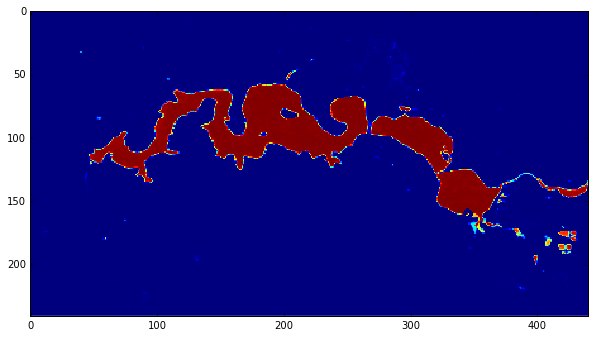

In [9]:
# Extract WOFS over region of interest:
yind_min = np.where( WOFS_lonvec>=dimensions['longitude']['range'][0] )[0][0]
yind_max = np.where( WOFS_lonvec<=dimensions['longitude']['range'][1] )[0][-1]
WOFS_lonvec = WOFS_lonvec[yind_min:yind_max+1]

xind_min = np.where( WOFS_latvec>=dimensions['latitude']['range'][1] )[0][-1]
xind_max= np.where( WOFS_latvec<=dimensions['latitude']['range'][0] )[0][0]
WOFS_latvec = WOFS_latvec[xind_min:xind_max+1]

WOFS_array = WOFS_array[xind_min:xind_max+1, yind_min:yind_max+1]
WOFS_geotx[0] = WOFS_geotx[0] + yind_min*WOFS_geotx[1]
WOFS_geotx[3] = WOFS_geotx[3] + xind_min*WOFS_geotx[5]

print(WOFS_geotx)
plt.imshow( WOFS_array, interpolation='none' );

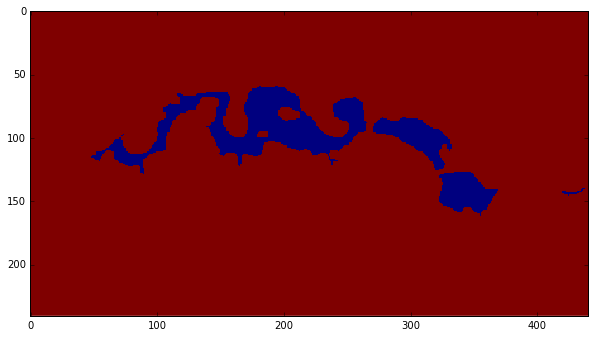

In [10]:
# generating the water / land mask:
land_mask = ( WOFS_array<=water_mask_thr )
land_mask = expand_mask( land_mask, water_mask_buffer )

plt.imshow( land_mask, interpolation='none' )

## Reprojecting WQ data, water masking, and saving to file

Ultimately, we'll need data in lat/lon geodetic projection (for visualisation). So we'll reproject the Landsat-based data to geodetic.

In [11]:
# Get info about the Landsat data...

# The following should be read from the data directly but this info does not seem 
# to be available/extractable from AE/EE's outputs... (?)
dc = datacube.api.API()
query = { 'product': 'NBAR',
          'platform': 'LANDSAT_5',
          'dimensions': dimensions }
L5data = dc.get_data( query )

L5_proj_str = L5data['coordinate_reference_systems'][1]['reference_system_definition']
L5_proj = osr.SpatialReference()
L5_proj.ImportFromWkt( L5_proj_str )

# Things that we can infer from the AE/EE results:
L5xvec = ee.cache['aeWQ_PQmsk']['array_result']['aeWQ_PQmsk']['x'].values
L5yvec = ee.cache['aeWQ_PQmsk']['array_result']['aeWQ_PQmsk']['y'].values
L5pix_size = np.mean(L5xvec[1:] - L5xvec[:-1])
L5_geotx = ( L5xvec[0], L5pix_size, 0, L5yvec[0], 0, -L5pix_size )

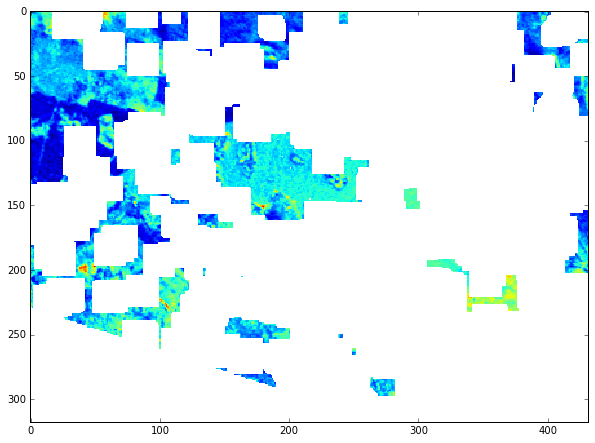

In [12]:
# "Save" WQ dataset as gdal dataset
dx, dy = WQ_TS_arr[0].shape
gdal_WQ_data = gdal.GetDriverByName( 'MEM' ).Create('', dy, dx, 1, gdal.GDT_Float32)
gdal_WQ_data.SetGeoTransform( L5_geotx )
gdal_WQ_data.SetProjection( L5_proj.ExportToWkt() )

dateind = 3   # Just selecting one date for the sake of example... This is where we'd need to loop over the dates!
gdal_WQ_data.GetRasterBand(1).WriteArray( WQ_TS_arr[dateind], 0, 0);

plt.imshow( gdal_WQ_data.ReadAsArray(), interpolation='none' );

(149.06, 0.00025, 0.0, -35.27, 0.0, -0.00025)
[149.06, 0.00025, 0.0, -35.270000000000003, 0.0, -0.00025]
(241, 441)
(241, 441)


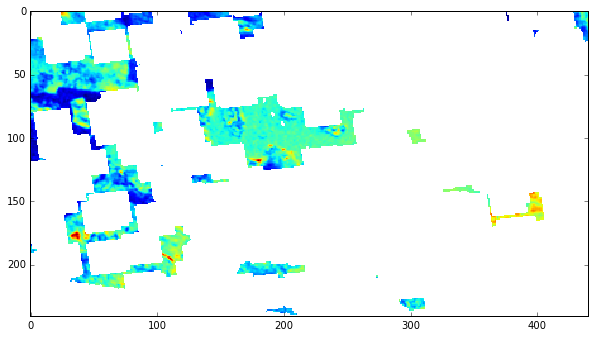

In [13]:
# Reprojecting the WQ gdal dataset to match the WOFS coordinates:
(dx, dy) = WOFS_array.shape
gdalgeo_WQ_data = gdal.GetDriverByName( 'MEM' ).Create('', dy, dx, 1, gdal.GDT_Float32)
gdalgeo_WQ_data.SetGeoTransform( WOFS_geotx )
gdalgeo_WQ_data.SetProjection( WOFS_proj )
gdalgeo_WQ_data.GetRasterBand(1).WriteArray( np.ones((dx,dy))*np.nan, 0, 0)

res = gdal.ReprojectImage( gdal_WQ_data, gdalgeo_WQ_data, 
                           L5_proj.ExportToWkt(), WOFS_proj, 
                           gdal.GRA_Bilinear )  # gdal.GRA_NearestNeighbour by default

WQ_array = gdalgeo_WQ_data.ReadAsArray()
plt.imshow( WQ_array, interpolation='none' );
print( gdalgeo_WQ_data.GetGeoTransform() )
print( WOFS_geotx )
print( WQ_array.shape )
print( land_mask.shape )

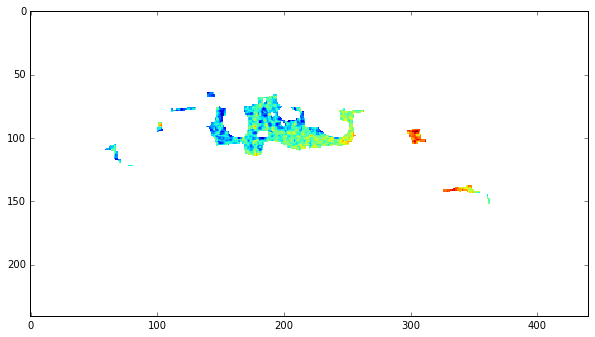

In [14]:
# Masking non-water pixels out:
WQ_array[land_mask] = np.nan
plt.imshow( WQ_array, interpolation='none' );

In [15]:
# Saving image to file, only if enough valid data...
f_basename = "WQ_" + lake_str + "_" + strL5_dates[dateind]
png_fname = f_basename + ".png"

n_water_pix = np.sum( ~land_mask )
n_valid_pix = np.sum( ~np.isnan(WQ_array) )
if (100.0*n_valid_pix/n_water_pix)>=min_valid_pix_thr:
    img.imsave(png_fname, WQ_array)

In [16]:
# Save ancillary data to .json file:
dx, dy = WQ_array.shape
gtx = gdalgeo_WQ_data.GetGeoTransform()
srs = osr.SpatialReference( wkt=WOFS_proj )

json_dict = { 'name': lake_str,
              'displayName': lake_dispname,
              'date': strL5_dates[dateind],
              'image': png_fname,
              'EPSG': srs.GetAttrValue("AUTHORITY", 1),
              'TLcorner': [gtx[0], gtx[3]],
              'LRcorner': [gtx[0]+dy*gtx[1], gtx[3]+dx*gtx[5]],
              'minValue': float( np.nanmin( WQ_array ) ),
              'maxValue': float( np.nanmax( WQ_array ) ),
              'meanValue': float( np.nanmean( WQ_array ) ),
              'medianValue': float( np.nanmedian( WQ_array ) ),
              'flag': 'undefined',       # this needs to be determined from the data, using some user-defined threshold
              'lakeType': 'undefined' }  # this should be user-defined somehow...

fname = f_basename + ".json"
with open(fname, "w") as outfile:
    json.dump(json_dict, outfile, indent=4)